<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#A-temperature-forecasting-problem" data-toc-modified-id="A-temperature-forecasting-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A temperature-forecasting problem</a></span><ul class="toc-item"><li><span><a href="#Download-the-data" data-toc-modified-id="Download-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download the data</a></span></li></ul></li><li><span><a href="#Visualize-the-timeseries-for-the-entire-dataset" data-toc-modified-id="Visualize-the-timeseries-for-the-entire-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualize the timeseries for the entire dataset</a></span></li><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparing the data</a></span><ul class="toc-item"><li><span><a href="#Normalizing-the-data" data-toc-modified-id="Normalizing-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Normalizing the data</a></span></li><li><span><a href="#Generator-yielding-timeseries-samples-and-their-targets" data-toc-modified-id="Generator-yielding-timeseries-samples-and-their-targets-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generator yielding timeseries samples and their targets</a></span></li><li><span><a href="#Preparing-the-training,-validation,-and-test_generators" data-toc-modified-id="Preparing-the-training,-validation,-and-test_generators-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Preparing the training, validation, and test_generators</a></span></li></ul></li><li><span><a href="#A-basic-machine-learning-approach" data-toc-modified-id="A-basic-machine-learning-approach-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A basic machine learning approach</a></span></li><li><span><a href="#A-first-recurrent-baseline" data-toc-modified-id="A-first-recurrent-baseline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>A first recurrent baseline</a></span></li><li><span><a href="#Using-recurrent-dropout-to-fight-overfitting" data-toc-modified-id="Using-recurrent-dropout-to-fight-overfitting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Using recurrent dropout to fight overfitting</a></span></li><li><span><a href="#Stacking-recurrent-layers" data-toc-modified-id="Stacking-recurrent-layers-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Stacking recurrent layers</a></span></li><li><span><a href="#Using-bidirectional-RNNs" data-toc-modified-id="Using-bidirectional-RNNs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Using bidirectional RNNs</a></span></li></ul></div>

# A temperature-forecasting problem

## Download the data

!mkdir data

!cd data && mkdir -p jena_climate && cd jena_climate && wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/jena_climate/jena_climate_2009_2016.csv.zip')
data.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
Date Time          420551 non-null object
p (mbar)           420551 non-null float64
T (degC)           420551 non-null float64
Tpot (K)           420551 non-null float64
Tdew (degC)        420551 non-null float64
rh (%)             420551 non-null float64
VPmax (mbar)       420551 non-null float64
VPact (mbar)       420551 non-null float64
VPdef (mbar)       420551 non-null float64
sh (g/kg)          420551 non-null float64
H2OC (mmol/mol)    420551 non-null float64
rho (g/m**3)       420551 non-null float64
wv (m/s)           420551 non-null float64
max. wv (m/s)      420551 non-null float64
wd (deg)           420551 non-null float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
data.values.shape

(420551, 15)

The data consists of 420551 records. The data is recorded every 10 minutes.

# Visualize the timeseries for the entire dataset

In [5]:
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
from bokeh.plotting import figure, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [6]:
p1 = figure(x_axis_type="datetime", title="Temperature (ºC) ",
            plot_width=950, plot_height=300)
p1.grid.grid_line_alpha = 0.3
p1.xaxis.axis_label = "Time"
p1.yaxis.axis_label = "Temperature (ºC)"

In [7]:
hover = HoverTool(tooltips=[
    ("Temperature", "$y")
])

In [8]:
p1.add_tools(hover)


In [9]:
p1.line(pd.to_datetime(data['Date Time']),  data['T (degC)'], color='#33A02C',
        legend='Temperature (ºC)')
p1.legend.location = "top_left"
show(p1)

In [10]:
temp_data = data[:1440]
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 15 columns):
Date Time          1440 non-null object
p (mbar)           1440 non-null float64
T (degC)           1440 non-null float64
Tpot (K)           1440 non-null float64
Tdew (degC)        1440 non-null float64
rh (%)             1440 non-null float64
VPmax (mbar)       1440 non-null float64
VPact (mbar)       1440 non-null float64
VPdef (mbar)       1440 non-null float64
sh (g/kg)          1440 non-null float64
H2OC (mmol/mol)    1440 non-null float64
rho (g/m**3)       1440 non-null float64
wv (m/s)           1440 non-null float64
max. wv (m/s)      1440 non-null float64
wd (deg)           1440 non-null float64
dtypes: float64(14), object(1)
memory usage: 168.8+ KB


In [11]:
p2 = figure(x_axis_type="datetime", title="Temperature (ºC) ")
            #plot_width=950, plot_height=300)
p2.grid.grid_line_alpha = 0.3
p2.xaxis.axis_label = "Time"
p2.yaxis.axis_label = "Temperature (ºC)"
p2.add_tools(hover)
p2.scatter(pd.to_datetime(temp_data['Date Time']),  temp_data['T (degC)'], color='#33A02C',
        legend='Temperature (ºC)')
p2.legend.location = "top_left"
show(p2)

# Preparing the data

The exact formulation of the problem is as follows:
**Given data going as far back as lookback timesteps(a timestep is 10 minutes) and sampled every steps timesteps, can we predict the temperature in delay timesteps?**

We will use the following parameters:
1. `lookback = 720` -- Observations will go back 5 days
2. `steps=6` -- Observations will be sampled at one data point per hour.
3. `delay=144` -- Targets will be 24 hours in the future

To get started, we need to do the following:

## Normalizing the data

- Preprocess the data to a format a NN can ingest (numerical format). This is already done for us. But each timeseries in the data is on a different scale. We will normalize each timeseries independently so that they all take small values on a similar scale. 

In [12]:
float_data = data.drop(columns='Date Time').astype('float32')
float_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 14 columns):
p (mbar)           420551 non-null float32
T (degC)           420551 non-null float32
Tpot (K)           420551 non-null float32
Tdew (degC)        420551 non-null float32
rh (%)             420551 non-null float32
VPmax (mbar)       420551 non-null float32
VPact (mbar)       420551 non-null float32
VPdef (mbar)       420551 non-null float32
sh (g/kg)          420551 non-null float32
H2OC (mmol/mol)    420551 non-null float32
rho (g/m**3)       420551 non-null float32
wv (m/s)           420551 non-null float32
max. wv (m/s)      420551 non-null float32
wd (deg)           420551 non-null float32
dtypes: float32(14)
memory usage: 22.5 MB


In [13]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [14]:
float_data[:200000].describe()

p (mbar)       T (degC)       Tpot (K)   Tdew (degC)  \
count  200000.000000  200000.000000  200000.000000  2.000000e+05   
mean       -0.025204      -0.000002      -0.001028 -1.647949e-07   
std         1.000000       1.000000       1.000000  1.000000e+00   
min        -8.902838      -3.624658      -3.636161 -4.110953e+00   
25%        -0.613183      -0.684253      -0.670764 -6.473114e-01   
50%         0.030645       0.037575       0.039035  7.974633e-02   
75%         0.626131       0.722126       0.715323  7.509840e-01   
max         2.799370       3.025425       2.990471  2.251151e+00   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.000030       0.000011       0.000018       0.000006   
std         1.000000       1.000000       1.000000       1.000000   
min        -3.730688      -1.616934      -2.026369      -0.844129   
25%        -0.665650      -0.753381      -0.780565      -0.668522   
50%         0.199998      -0.203257      -0.132651      -0.391683   
75%         0.821734       0.548451       0.682005       0.296283   
max         1.473361       5.935251       3.569031       7.857709   

           sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  \
count  200000.000000    200000.000000  200000.000000  200000.000000   
mean       -0.000010         0.000010      -0.000537      -0.000017   
std         1.000000         1.000000       1.000000       1.000000   
min        -2.016479        -2.023757      -3.720665      -1.399801   
25%        -0.778509        -0.777307      -0.708117      -0.736027   
50%        -0.133265        -0.132915      -0.100193      -0.228435   
75%         0.677042         0.678453       0.613168       0.480892   
max         3.606903         3.589973       4.142323       8.120796   

       max. wv (m/s)       wd (deg)  
count  200000.000000  200000.000000  
mean       -0.000054      -0.000007  
std         1.000000       1.000000  
min        -1.531586      -2.034530  
25%        -0.759279      -0.515136  
50%        -0.227245       0.266498  
75%         0.515028       0.693684  
max         8.551313       2.121868

In [15]:
float_data.describe()

p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean        0.013287       0.042110       0.037665       0.070795   
std         0.985617       0.951522       0.949874       0.939269   
min        -8.902838      -3.624658      -3.636161      -4.110953   
25%        -0.577809      -0.645846      -0.639490      -0.587305   
50%         0.056591       0.038705       0.035125       0.107656   
75%         0.662685       0.722126       0.711973       0.784476   
max         3.095338       3.185831       3.147956       2.604214   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean        0.039080       0.025149       0.056424      -0.008982   
std         0.984984       1.006484       0.996682       1.011672   
min        -3.730688      -1.616934      -2.026369      -0.844129   
25%        -0.606465      -0.728671      -0.735306      -0.664390   
50%         0.235868      -0.203257      -0.104067      -0.391683   
75%         0.839669       0.548451       0.727263       0.250831   
max         1.473361       6.553004       4.531372       8.661368   

           sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  \
count  420551.000000    420551.000000  420551.000000  420551.000000   
mean        0.055210         0.055280      -0.034700      -0.292064   
std         0.996430         0.996077       0.940838      42.590008   
min        -2.016479        -2.023757      -3.720665   -6508.334473   
25%        -0.733492        -0.732623      -0.707175      -0.755550   
50%        -0.107005        -0.104694      -0.088189      -0.254466   
75%         0.722060         0.725489       0.593870       0.461369   
max         4.597278         4.565968       4.142323      17.140310   

       max. wv (m/s)       wd (deg)  
count  420551.000000  420551.000000  
mean       -0.220142      -0.017017  
std        29.612375       1.000788  
min     -4291.698242      -2.034530  
25%        -0.776442      -0.592491  
50%        -0.261570       0.252643  
75%         0.502156       0.668283  
max         8.551313       2.121868

In [16]:
float_data = float_data.values

## Generator yielding timeseries samples and their targets

- Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redudant (sample N and sample N+1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, we will generate the samples on th fly using the original data.

The generator yields a tuple `(samples, targets)` where `samples` is one batch of input data and `targets` is the corresponding array of target temperatures. It takes the following arguments:

1. `data`-- The original array of floating-point data, which we normalized
2. `lookback`-- How many timesteps back the input data should go
3. `delay`-- How many timesteps in the future the target should be
4. `min_index` and `max_index`--indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
5. `shuffle`--Whether to shuffle the samples or draw them in chronological order. 
6. `batch_size`-- The number of samples per batch
7. `step`-- The period, in timesteps , at which you sample data. 

In [17]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback

            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

## Preparing the training, validation, and test_generators

In [18]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [19]:
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0,
                      max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001,
                      max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001,
                      max_index=None, step=step, batch_size=batch_size)

In [20]:
# How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size
# How many steps to draw from test_gen in order to see the entire test_set
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# A basic machine learning approach

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [22]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))


In [23]:
model.compile(optimizer=RMSprop(), loss='mae')

In [24]:
%%time
history = model.fit_generator(train_gen, steps_per_epoch=200,
                              epochs=10, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/10
200/200 [==============================] - 12s 61ms/step - loss: 1.4993 - val_loss: 0.9558
Epoch 2/10
200/200 [==============================] - 10s 50ms/step - loss: 0.6713 - val_loss: 0.4287
Epoch 3/10
200/200 [==============================] - 10s 48ms/step - loss: 0.4202 - val_loss: 0.3476
Epoch 4/10
200/200 [==============================] - 10s 49ms/step - loss: 0.3357 - val_loss: 0.4476
Epoch 5/10
200/200 [==============================] - 10s 48ms/step - loss: 0.3065 - val_loss: 0.3516
Epoch 6/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2878 - val_loss: 0.3291
Epoch 7/10
200/200 [==============================] - 9s 47ms/step - loss: 0.2790 - val_loss: 0.3382
Epoch 8/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2731 - val_loss: 0.3340
Epoch 9/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2665 - val_loss: 0.3041
Epoch 10/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2588

In [25]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [26]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

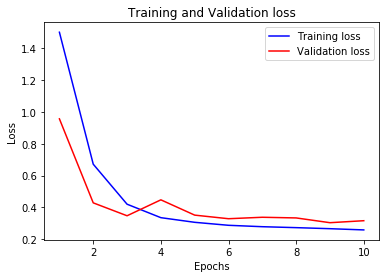

In [27]:
plot_history(history)

# A first recurrent baseline

Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the LSTM layer introduced in the previous section, we will use the GRU layer, developed by Cho et al. in 2014. GRU layers (which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [28]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer=RMSprop(), loss='mae')

In [32]:
%%time
history = model.fit_generator(train_gen, steps_per_epoch=200,
                              epochs=10, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/10
200/200 [==============================] - 116s 578ms/step - loss: 0.3116 - val_loss: 0.2791
Epoch 2/10
200/200 [==============================] - 115s 575ms/step - loss: 0.2920 - val_loss: 0.2766
Epoch 3/10
200/200 [==============================] - 116s 578ms/step - loss: 0.2910 - val_loss: 0.2719
Epoch 4/10
200/200 [==============================] - 114s 571ms/step - loss: 0.2811 - val_loss: 0.2692
Epoch 5/10
200/200 [==============================] - 115s 574ms/step - loss: 0.2829 - val_loss: 0.2716
Epoch 6/10
200/200 [==============================] - 115s 576ms/step - loss: 0.2795 - val_loss: 0.2655
Epoch 7/10
200/200 [==============================] - 115s 573ms/step - loss: 0.2746 - val_loss: 0.2662
Epoch 8/10
200/200 [==============================] - 114s 571ms/step - loss: 0.2717 - val_loss: 0.2637
Epoch 9/10
200/200 [==============================] - 114s 572ms/step - loss: 0.2750 - val_loss: 0.2727
Epoch 10/10
200/200 [==============================] - 114s 571m

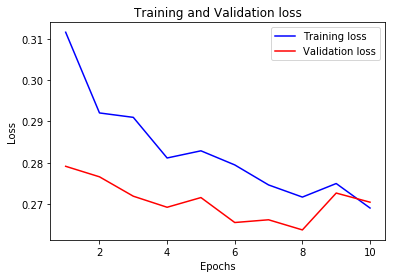

In [33]:
plot_history(history)

# Using recurrent dropout to fight overfitting

It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs.


In [34]:
model = Sequential()
model.add(
    layers.GRU(
        32,
        dropout=0.2,
        recurrent_dropout=0.2,
        input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [35]:
model.compile(optimizer=RMSprop(), loss='mae')

In [36]:
%%time
history = model.fit_generator(
    train_gen,
    steps_per_epoch=200,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps)

Epoch 1/10
200/200 [==============================] - 135s 676ms/step - loss: 0.3439 - val_loss: 0.2767
Epoch 2/10
200/200 [==============================] - 135s 673ms/step - loss: 0.3279 - val_loss: 0.2753
Epoch 3/10
200/200 [==============================] - 134s 672ms/step - loss: 0.3198 - val_loss: 0.2722
Epoch 4/10
200/200 [==============================] - 134s 670ms/step - loss: 0.3170 - val_loss: 0.2729
Epoch 5/10
200/200 [==============================] - 135s 675ms/step - loss: 0.3144 - val_loss: 0.2721
Epoch 6/10
200/200 [==============================] - 135s 673ms/step - loss: 0.3121 - val_loss: 0.2709
Epoch 7/10
200/200 [==============================] - 135s 674ms/step - loss: 0.3067 - val_loss: 0.2704
Epoch 8/10
200/200 [==============================] - 134s 671ms/step - loss: 0.3071 - val_loss: 0.2719
Epoch 9/10
200/200 [==============================] - 134s 670ms/step - loss: 0.3032 - val_loss: 0.2718
Epoch 10/10
200/200 [==============================] - 134s 672m

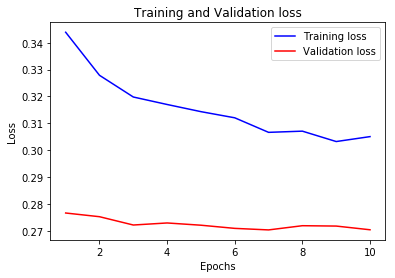

In [37]:
plot_history(history)



Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best scores are not much lower than they were previously.

# Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True:


```python
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
```

This does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

- Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss improvement. This does have a non-negligible computational cost, though.
- Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this point.

# Using bidirectional RNNs

The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets). Training the same one-GRU-layer network as we used in the first experiment in this section, we get the following results:


In [38]:
def reverse_order_generator(data,
                            lookback,
                            delay,
                            min_index,
                            max_index,
                            shuffle=False,
                            batch_size=128,
                            step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets



In [39]:
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [40]:
%%time 
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=200,
                              epochs=10,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)



Epoch 1/10
200/200 [==============================] - 117s 585ms/step - loss: 0.4902 - val_loss: 0.4865
Epoch 2/10
200/200 [==============================] - 117s 583ms/step - loss: 0.4759 - val_loss: 0.4813
Epoch 3/10
200/200 [==============================] - 117s 583ms/step - loss: 0.4628 - val_loss: 0.4762
Epoch 4/10
200/200 [==============================] - 117s 583ms/step - loss: 0.4517 - val_loss: 0.4684
Epoch 5/10
200/200 [==============================] - 117s 583ms/step - loss: 0.4339 - val_loss: 0.4778
Epoch 6/10
200/200 [==============================] - 116s 582ms/step - loss: 0.4170 - val_loss: 0.4790
Epoch 7/10
200/200 [==============================] - 116s 582ms/step - loss: 0.4011 - val_loss: 0.4828
Epoch 8/10
200/200 [==============================] - 118s 590ms/step - loss: 0.3877 - val_loss: 0.4834
Epoch 9/10
200/200 [==============================] - 117s 583ms/step - loss: 0.3777 - val_loss: 0.4738
Epoch 10/10
200/200 [==============================] - 116s 581m

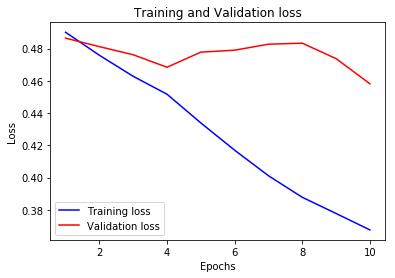

In [41]:
plot_history(history)

So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's try the same trick on the LSTM IMDB example from the previous section:

In [42]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)



17465344/17464789 [==============================] - 0s 0us/step
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.4906 - acc: 0.7668 - val_loss: 0.3362 - val_acc: 0.8700
Epoch 2/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.3049 - acc: 0.8840 - val_loss: 0.4271 - val_acc: 0.8042
Epoch 3/10
20000/20000 [==============================] - 152s 8ms/step - loss: 0.2550 - acc: 0.9040 - val_loss: 0.3460 - val_acc: 0.8582
Epoch 4/10
20000/20000 [==============================] - 152s 8ms/step - loss: 0.2161 - acc: 0.9200 - val_loss: 0.3696 - val_acc: 0.8800
Epoch 5/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.1883 - acc: 0.9325 - val_loss: 0.3847 - val_acc: 0.8750
Epoch 6/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.1721 - acc: 0.9416 - val_loss: 0.4009 - val_acc: 0.8692
Epoch 7/10
20000/20000 [==============================] - 



We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our hypothesis that, albeit word order does matter in understanding language, which order you use isn't crucial. Importantly, a RNN trained on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and you were born on your last day. In machine learning, representations that are different yet useful are always worth exploiting, and the more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![](assets/birnn.png)


To instantiate a bidirectional RNN in Keras, one would use the Bidirectional layer, which takes as first argument a recurrent layer instance. Bidirectional will create a second, separate instance of this recurrent layer, and will use one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the IMDB sentiment analysis task:

In [43]:
from keras import backend as K
K.clear_session()

In [44]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 279s 14ms/step - loss: 0.5463 - acc: 0.7260 - val_loss: 0.4727 - val_acc: 0.7880
Epoch 2/10
20000/20000 [==============================] - 278s 14ms/step - loss: 0.3260 - acc: 0.8744 - val_loss: 0.3067 - val_acc: 0.8858
Epoch 3/10
20000/20000 [==============================] - 277s 14ms/step - loss: 0.2647 - acc: 0.9028 - val_loss: 0.3484 - val_acc: 0.8832
Epoch 4/10
20000/20000 [==============================] - 276s 14ms/step - loss: 0.2272 - acc: 0.9182 - val_loss: 0.3027 - val_acc: 0.8812
Epoch 5/10
20000/20000 [==============================] - 275s 14ms/step - loss: 0.2034 - acc: 0.9289 - val_loss: 0.3505 - val_acc: 0.8864
Epoch 6/10
20000/20000 [==============================] - 277s 14ms/step - loss: 0.1830 - acc: 0.9375 - val_loss: 0.4808 - val_acc: 0.8118
Epoch 7/10
20000/20000 [==============================] - 273s 14ms/step - loss: 0.1664 - acc: 0.9437 - val_loss: 0.4

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:


In [46]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=2,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/2
100/100 [==============================] - 155s 2s/step - loss: 0.3331 - val_loss: 0.2868
Epoch 2/2
100/100 [==============================] - 155s 2s/step - loss: 0.2961 - val_loss: 0.2794


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).
Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

- Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely suboptimal.
- Adjust the learning rate used by our RMSprop optimizer.
- Try using LSTM layers instead of GRU layers.
- Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger Dense layer or even a stack of Dense layers.
- Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing architectures that are overfitting to the validation set.

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.
Wrapping up

Here's what you should take away from this section:

- when approaching a new problem, it is good to first establish common sense baselines for your metric of choice. If you don't have a baseline to beat, you can't tell if you are making any real progress.
- Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
- On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.
- To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras recurrent layers, so all you have to do is use the dropout and recurrent_dropout arguments of recurrent layers.
- Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
- Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will leave them for future study outside of this book.


In [47]:
%load_ext version_information
%version_information keras, numpy, matplotlib, pandas

Software versions
Python 3.5.2 64bit [GCC 5.4.0 20160609]
IPython 6.2.1
OS Linux 4.4.0 1048 aws x86_64 with Ubuntu 16.04 xenial
keras 2.1.2
numpy 1.14.0
matplotlib 2.1.0
pandas 0.22.0
Fri Jan 12 07:51:44 2018 UTC